# Introduction

There has been conversation about the use of the standardized testing, such as the SAT, across the US and if its use is fair all, or whether there are particular groups for which it is unfair. SAT scores are important to students and schools alike - the scores often play an intergral role in student admission to colleges, while the scores are also used as an indicator overall school district performance.

In this project, SAT scores will be compared with different demographic information to identify any groups for which the SAT test format may offer unfair advantages and disadvantages.

In this guided project, data from the City of New York will be cleaned analysed to review SAT performance across groups and demographics. The datasets being used include SAT scores, demographics for each high school, and survey responses from teachers, parents and students from schools in NYC.

## Introducing the Data

All data used in this project is available through the City of New York.

The data sets that we will be cleaning, combining and analysing are:
- SAT scores by school across New York City
- Attendance information for each school
- Class size
- Advanced Placement (AP) results for each school
- Graduation outcomes - percentage of students who graduated and other outcomes
- Demographics information for each school
- Surey information of teachers, parents and students at each school

Background information and understanding on the data and what we are analyzing is imperative. For example:
- The SAT test is taken by high school students, so we will need to focus on high schools
- Understanding New York boroughs and school districts
- Each school in NYC has its own unique number called a 'DBN' (District Borough Number)

All the data sets include important and necessary information for our analysis, and so will need to be combined.

### Reading in the data files

In [623]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

#reading multiple files into a dictionary through a 'for loop'
for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Previewing the data

In [624]:
#print top rows using 'sat_results' key from 'data' dictionary
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


Based on these first few rows of the 'SAT Results' data, there a couple of takeaways:
- the data includes each school's unique DBN number
- the school names imply we only have high schools in these data
- the SAT results are separated into critical reading, math and writing average scores - we will want to combine these for a total average SAT score

In [625]:
#printing top 5 rows dor each dataframe in the data dictionary
for d in data:
    print(data[d].head())

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

Most data sets contain the "DBN" number for each school. However, there are dataframes in which the DBN is repeated for multiple entries. For mapping purposes, we will need to ensure that each DBN is unique within each dataframe.

### Reading in the survey files with encoding

The survey text files are *tab delimited* and encoded with 'Windows-1252' encoding.

In [626]:
#specifying delimiter and encoding information
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')

#concatenating the read text files to form one dataframe, appending 'd75_survey' to bottom of 'all_survey'
survey = pd.concat([all_survey, d75_survey], axis=0)

survey.head()

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.0,Elementary / Middle School,89.0,73,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,M063,P.S. 063 William McKinley,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning the Data 

### Cleaning the "survey" dataframe

##### Extracting and renaming columns

There are two initial actions to be taken to make the survey easier to work with:

- This dataframe has over 2000 columns, most of which we won't need. Using the df.loc method allows us to extract only the columns we select.

- The survey dataframe also includes a column with the schools' DBN data, but the column name needs to be updated to uppercase characters to match the other dataframes.

In [627]:
#copying 'dbn' column data in to a new column with name 'DBN'
survey["DBN"] = survey["dbn"]

#list of columns to extract/keep
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

#using df.loc methos to select only the columns with the listed names
survey = survey.loc[:,survey_fields]
data["survey"] = survey

survey.head()

,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,7.6,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,8.9,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,6.8,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,6.8,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,7.8,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


In [628]:
survey.shape

(1702, 23)

### Adding missing fields

The "hs_directory" dataset just needs to have the "dbn" column name updated to "DBN".

In [629]:
#creating column field from "dbn" column with "DBN" column name
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

##### Creating DBNs by combining data in columns

The "class_size" data set is missing the DBN (each school's unique identification number) that is present in the other data sets. 

The DBN is a combination of the CSD (City School District) number and the school code. Both of these are in the data set so we can can create the DBN in a new column.

To form the DBN, the CSD number needs to be padded with two digits (ie, 1 shows as 01, and 12 shows as 12).

This can be done by creating a custom function that takes in a number and checks the length of the string - if there are two digits, it returns the string, otherwise it returns the single-digit string with a '0' before. For this we can use the 'zfill()' string method.

In [630]:
#creating a custom function taking in number, and returning padded CSD with 2 digits using zfill string method
def pad_csd(n):
    return str(n).zfill(2)

#creating new "padded_csd" column within the "class size" data set (key) of the 'data' dictionary
#new column contains data where custom function has been applied to the CSD column to return padded CSD
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

#create new "DBN" column combining 'padded_csd' and 'school code' columns
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

#preview the updated dataframe
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


### Combining SAT scores

It would be handy to have the SAT scores as a total, rather than separated by subject. Therefore, a column will be added with the total average SAT score.

The scores are currently in string format, but need to be converted to numeric values so that they can be summed.

##### Converting strings to numeric data

In [631]:
#list of column names with data to be converted to numeric values
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

#must add 'errors="coerce"' to return untranslatable strings as missing values when using pandas.to_numeric() function
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

#new 'sat_score' column within 'sat_results' summing 3 columns included in 'cols' list
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]


### Parsing geographic coordinates for schools

The 'hs_directory' dataset contains the longitude and latitude coordinates for each school.

In [632]:
data['hs_directory'].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,DBN
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",17K548
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",09X543
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to New York City residents who attend an ...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",09X327
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\nNew York, NY 10038\n(40.7106...",02M280
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,Then to Queens students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40...",28Q680


The coordinates are located in the "Location 1" column along with the address of each school. They can be parsed by using regular expressions to extract them.

In [633]:
#import regular expressions module
import re

#define function that takes in a string, extracts the coordinates, uses string manipulation to pull out and return latitude
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

#define function to parse longitude
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

#use series.apply() to apply funcion and assign to new columns "lat" and "lon"
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

#convert to numeric data
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

#preview dataset with new columns
data['hs_directory'].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,DBN,lat,lon
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",17K548,40.670299,-73.961648
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",09X543,40.827603,-73.904475
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",09X327,40.842414,-73.916162
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\nNew York, NY 10038\n(40.7106...",02M280,40.710679,-74.000807
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40...",28Q680,40.718810,-73.806500


## Condensing Data Sets

### Condensing the class size data set

The 'class_size' data set contains a column containing grade information. Since we are reviewing high school data, we can condense the data set so that it only contains data that is relevent to grades 9-12.

There is also a column specifying the type of program. Only 'GEN ED' or General Education will be considered for this analysis, since it is the most popular.


In [634]:
class_size = data["class_size"]
print(class_size.head(5))

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


In [635]:
list(class_size)

['CSD',
 'BOROUGH',
 'SCHOOL CODE',
 'SCHOOL NAME',
 'GRADE ',
 'PROGRAM TYPE',
 'CORE SUBJECT (MS CORE and 9-12 ONLY)',
 'CORE COURSE (MS CORE and 9-12 ONLY)',
 'SERVICE CATEGORY(K-9* ONLY)',
 'NUMBER OF STUDENTS / SEATS FILLED',
 'NUMBER OF SECTIONS',
 'AVERAGE CLASS SIZE',
 'SIZE OF SMALLEST CLASS',
 'SIZE OF LARGEST CLASS',
 'DATA SOURCE',
 'SCHOOLWIDE PUPIL-TEACHER RATIO',
 'padded_csd',
 'DBN']

In [636]:
#display unique values in "GRADE " and "PROGARM TYPE" columns
class_size['GRADE '].unique().tolist()

['0K',
 '01',
 '02',
 '03',
 '04',
 '05',
 '0K-09',
 nan,
 '06',
 '07',
 '08',
 'MS Core',
 '09-12',
 '09']

In [637]:
class_size['PROGRAM TYPE'].unique().tolist()

['GEN ED', 'CTT', 'SPEC ED', nan, 'G&T']

In [638]:
#extract rows with grade 9-12 and 'Gen Ed'
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


##### Computing average class sizes

In order to merge the data sets successfully, the DBNs in each data set should be unique.

The preview of the class_size data set above shows that we still have multiple rows of data with the same DBNs, due to the 'CORE SUBJECT (MS CORE and 9-12 ONLY)' and 'CORE COURSE (MS CORE and 9-12 ONLY)' columns.

We can condense the data set down by calculating the average class size for each DBN, and hence school.

In [639]:
#use groupby() method to separate data into groups sharing same DBN and aggregate mean averages
class_size = class_size.groupby("DBN").agg(numpy.mean)

#use reset_index() to restore 'DBN' as a column, and not the index
class_size.reset_index(inplace=True)
data["class_size"] = class_size

#preview condensed data set
class_size.head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


### Condensing the demographics data set

In [640]:
data["demographics"].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In [641]:
data['demographics']['schoolyear'].unique()

array([20052006, 20062007, 20072008, 20082009, 20092010, 20102011,
       20112012])

In this data set, the 'schoolyear' column is the cause of repeated DBNs. We are looking to use the most recent data for our analysis which is 2011-2012.

In [642]:
#filter data set to 2011-2012
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

#preview condensed data set
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


### Condensing the graduation data set

In [643]:
#previewing the graduation data set
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


In [644]:
#unique demographic values
data['graduation']['Demographic'].unique()

array(['Total Cohort', 'Male', 'English Language Learners',
       'English Proficient Students', 'Special Education Students',
       'General Education Students', 'Asian', 'Black', 'Hispanic',
       'White', 'Female'], dtype=object)

In [645]:
#unique cohort values
data['graduation']['Cohort'].unique()

array(['2003', '2004', '2005', '2006', '2006 Aug', '2001', '2002'],
      dtype=object)

The graduation data set also needs to be condensed to have unique DBNs. The 'demographic' and 'cohort' columns are the drivers of multiple DBNs in this data set.

'Demographic' refers to specific demographic groups, while 'Cohort' refers to the year the data represents.

In order to condense this data set down to unique DNBs:
- 'Cohort' values will be filtered to the most recent data available - 2006
- 'Demographic' values will be filtered to 'Total Cohort' since we want the entire cohort's graduation data

In [646]:
#condensing/filtering the graduation data
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

#previewing the condensed data set
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


## Converting AP scores

The 'ap_2010' data set contains information about the scores of Advanced Placement (AP) tests. High school students can earn college credit if they get high scores in these tests.

AP exams are more prevalent in more academically challenging insitutions, and a lot less common in schools that receive less funding or less academically rigorous. One might wonder if there is any 

A passing score is 3 or above, out of a possible 5.

In [647]:
data['ap_2010'].head()

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39,49,10
1,01M450,EAST SIDE COMMUNITY HS,19,21,s
2,01M515,LOWER EASTSIDE PREP,24,26,24
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255,377,191
4,02M296,High School of Hospitality Management,s,s,s


In [648]:
data['ap_2010'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   DBN                                   258 non-null    object
 1   SchoolName                            258 non-null    object
 2   AP Test Takers                        258 non-null    object
 3   Total Exams Taken                     258 non-null    object
 4   Number of Exams with scores 3 4 or 5  258 non-null    object
dtypes: object(5)
memory usage: 10.2+ KB


All data in the set is in string format. In order to analyse the data and look for correlations, there are three columns that need to be converted to numeric form:
- 'AP Test Takers'
- 'Total Exams Taken'
- 'Number of Exams with scores 3 4 or 5' - ie, a passing score

In [649]:
#listing columns to be converted
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

#converting data to numeric form
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")
    
#review info to confirm data conversion
data['ap_2010'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   DBN                                   258 non-null    object 
 1   SchoolName                            258 non-null    object 
 2   AP Test Takers                        233 non-null    float64
 3   Total Exams Taken                     233 non-null    float64
 4   Number of Exams with scores 3 4 or 5  151 non-null    float64
dtypes: float64(3), object(2)
memory usage: 10.2+ KB


## Combining the Data Sets

The 'DBN' values within our data sets will be used to identify the matching rows between them.

Some data sets might have DBNs that don't exist in others, especially since the data has been collected through different years.

Two data sets will be merged at a time, until all data sets are merged. Every row should end up with the columns from every data set.

##### Considerations for deciding on merge strategy

There are several merge options, each with their own advantages.

Since this project and analysis are focused on SAT scores, we want to preserve as much of the SAT results data as possible.

An **inner join** will be used to merge most of the datasets, since we want to be left with DBNs that have data in SAT results, and data in the columns referencing class size, demographics, survey and the school directory information for our analysis.

A **left join** will be used to merge AP and graduation information with the SAT results - we run the risk of losing too many DBNs if we don't prioritise keeping the SAT results.


In [650]:
#define combined data set starting with SAT results
combined = data["sat_results"]

#merge ap_2010 and graduation data sets with a left merge, using DBNs
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

#create list of other data sets to be merged using inner merge
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

#iterate through other data sets to merge all with inner join
for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

#fill in null values with the mean value of each column
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

#preview combined dataset for analysis
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


### Adding a school district column for mapping

As previously mentioned, the DBNs contain the school district code and the school code. Using the DBN data, we can extract the school district and add this data to a new column for school district-level analysis.

In [651]:
#define function to return school district code from DBN
def get_first_two_chars(dbn):
    return dbn[0:2]

#apply function to create new column with school district code
combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

In [652]:
combined.shape

(363, 160)

# Analyzing and Visualizing the Data

## Finding correlations

In [653]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"


In [654]:
#find all possible correlations in data set
correlations = combined.corr()

#filter df only to correlations between SAT scores and the other columns
correlations = correlations["sat_score"]

#print full output
print(correlations.to_string())

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

A few obvservations from the correlation values listed above:

- Unsurprisingly, values that are SAT scores (*SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score*) have a very high positive correlation.
- Strong negative relationships exist between SAT scores and the percentage of foreign language learners in the school (*frl_per, ell_per*).
- There are noticeable differences when comparing the relationships from a racial perspective (*asian_per, black_per, hispanic_per, white_per*).
- Class size has a positive relationship with SAT scores, which is interesting since there is generally an assumption that smaller classes in a school would result in better test results (*total_enrollment*).
- There is a positive correlation between the both the number and percentage of females in a school (*female_per, female_num*), whereas the male percentage of students has a negative correlation (*male_num*).
- The safety of students, teachers and parents has a relationship with SAT scores (*saf_s_11, saf_t_11, saf_p_11, saf_tot_11*).

#### Total enrollment vs SAT scores

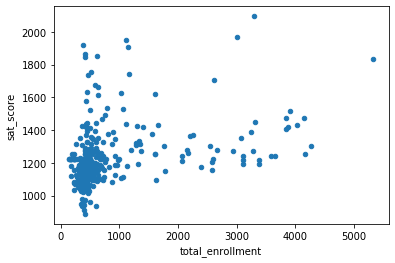

In [655]:
import matplotlib.pyplot as plt
%matplotlib inline

#create scatter plot
combined.plot.scatter(x='total_enrollment', y='sat_score')

plt.show()

This plot doesn't reflect a *strong* relationship between class size and SAT score, since there is a cluster of schools and others going off in all directions.

Investigating the schools with low enrollment and low SAT scores could help to understand what is causing a strong r value.

In [656]:
#filtering schools to lowest enrollment and SAT scores
low_enrollment = combined[combined['total_enrollment'] < 1000]
low_enrollment = combined[combined['sat_score'] < 1000]

print(low_enrollment['School Name'])

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


Almost all of these schools are specialised to recent immigrants who don't speak English as a first language.

These schools have a high percentage of english language learners. We noticed a relationship between the percentage of english language learners and SAT scores previously, so we will investigate this further.

#### English language learners vs SAT scores

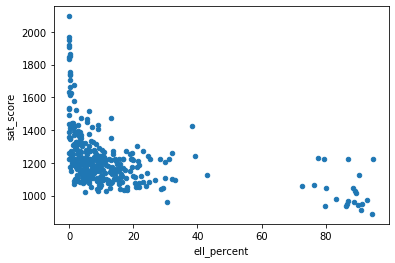

In [657]:
combined.plot.scatter(x='ell_percent', y='sat_score')

plt.show()

The plot reflects a negative relationship between percentage of english language learners in a school and SAT score, where all schools with an english language learners percentage higher than 40% coming in with scores below 1300.

### Calculating district-level statistics

Viewing data at the granular, school-by-school, level can serve a purpose, but we can also aggregate data to a higher level to make higher-level takeaways.

Similarly to before, the data will be aggregated to mean averages for each school district.

In [658]:
import numpy

districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


### Plotting survey correlations

In [659]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

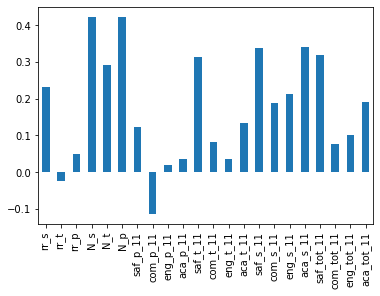

In [660]:
combined.corr()['sat_score'][survey_fields].plot.bar()

There are stronger relationships between the number of students and parents. This isn't surprising since the number of parents and students relates to total enrollment, which we previously identified as having a correlation with sat score.

The rr_s column, student response rate, has a meaningful relationship with the sat score. This would make sense as students who are engaged in their academics are more likely to participate in surveys regarding their academics.

Another area of interest is the relationship between saf_t_11 and saf_s_11, which refer to the teachers' and students' perception of safety at the school, and the sat score.

### Borough Safety

When reviewing r numbers for every column, there appeared to be a relationship between safety and SAT scores.

##### Student safety vs SAT scores

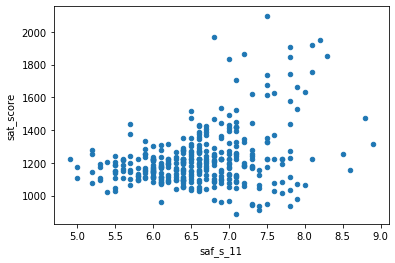

In [674]:
combined.plot.scatter('saf_s_11','sat_score')

The scatter plot shows a relationship where the sat scores are lower where students perceive their safety at school to be lower. This could be a result a of students not wanting to engage in school and academic activities when they don't feel safe.

##### Computing safety scores for each borough

In [662]:
boro_s = combined.groupby('boro').agg(numpy.mean)['saf_s_11']
print(boro_s)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


Manhattan and Queens obtained the highest safety scores while Brooklyn has the lowest score. Reviewing crime statistics by borough, Brooklyn has the most dangerous neighbourhoods and highest crime stats, while Manhattan and Queens have the least.

### Racial Differences

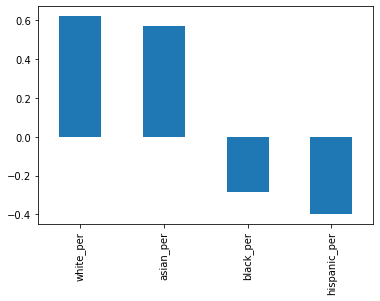

In [663]:
race_cols = ['white_per','asian_per', 'black_per', 'hispanic_per']

combined.corr()['sat_score'][race_cols].plot.bar()

Schools with higher percentages of white and asian students have a more positive correlation with sat score, while higher black and hispanic percentages have a negative relationship with sat scores.

There are many contributing factors, such as the location of the school which could be in an area with a lower safety score, or an area with less school funding. 

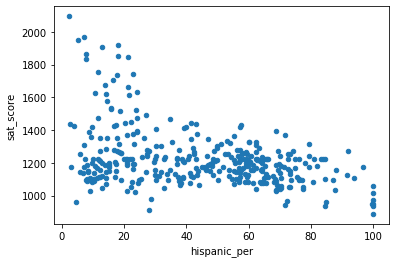

In [664]:
combined.plot.scatter('hispanic_per','sat_score')

The plot shows a negative relationship where the sat scores decrease as the percentage of hispanic students increases.

In [665]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools above are insitutions that are targeted to recent immigrants from non-English speaking countries - primarily Spanish-speaking countries. Since English isn't their first language or could be new to them, that could be a contributing factor to the lower sat scores.

In [666]:
print(combined[(combined["hispanic_per"]<10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools require entrance exams with very low acceptance rates, and many specialise in maths and science that receive additional funding. There is no explanation for the lower percentage of hispanic students, however the higher sat scores are no surprising when students have been selected and had to pass entrace exams.

### Gender

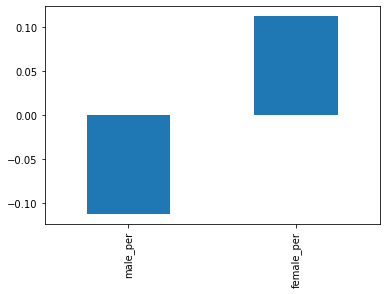

In [667]:
gender_cols = ['male_per', 'female_per']

combined.corr()['sat_score'][gender_cols].plot.bar()

Schools with a higher percentage of female students have a positive correlation with SAT scores, while higher percentages of male students have a negative relationship, however these relationships are not particularly srong with correlations around 0.1 and -0.1

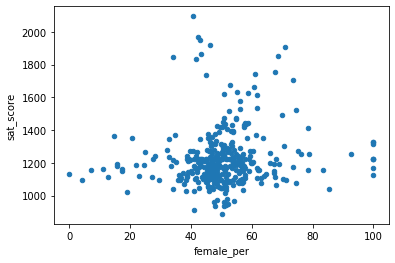

In [668]:
combined.plot.scatter('female_per','sat_score')

There isn't a clear correlation between the SAT score and percentage of female students, but there is a cluster of schools with the highest SAT scores where the female percentage is around 40%-80%.

In [669]:
print(combined[(combined['female_per']>60) & (combined['sat_score']>1700)]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appear to have high academic standards and can afford to be very selective in whom they admit, may it by way of academic entry exams, portfolio selection or auditions.

### AP Participation

In [670]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

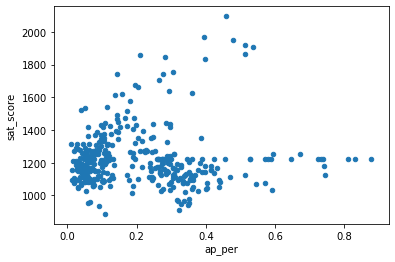

In [671]:
combined.plot.scatter('ap_per','sat_score')

While the scatter plot show a slight relationship between the percentage of students who took an AP exam and SAT score, the relationship is not strong.